# Imports

In [2]:
# !pip install adjustText

from matplotlib        import collections             as matcoll
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import TwoSlopeNorm
from matplotlib.pyplot import rc_context
from scipy.cluster     import hierarchy
from adjustText        import adjust_text

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import math
import glob
import h5py
import sys
import os

main_path = '/raid/users/farzaneh/Histomorphological-Phenotype-Learning'
import warnings
warnings.filterwarnings("ignore")

sys.path.append(main_path)
from models.clustering.logistic_regression_leiden_clusters import *
from models.evaluation.folds import load_existing_split
from models.clustering.correlations import *
from models.clustering.data_processing import *
from models.clustering.leiden_representations import include_tile_connections_frame
from data_manipulation.utils import store_data
from IPython.display import clear_output
clear_output()

# Methods

In [39]:
def create_histo_annotation_df(h5_hist_anno_path, additional_df):
    with h5py.File(h5_hist_anno_path, 'r') as content:
        slides   = [slide.decode("utf-8").split('_')[0] for slide in content['combined_slides']]
        tiles    = [tile.decode("utf-8").split('.')[0] for tile in content['combined_tiles']]
        histtype = [type_.decode("utf-8") for type_ in content['combined_hist_subtype']]
        histo_df = pd.DataFrame(slides, columns=['slides'])
        histo_df['tiles'] = tiles
        histo_df['histtype'] = histtype

    selected_anno = ['acinar', 'lepidic', 'micropapillary', 'papillary', 'solid']

    additional_df['slides'] = additional_df['slides'].astype(str)
    histo_complete_df = additional_df.merge(histo_df, how='inner', left_on=['slides','tiles'], right_on=['slides','tiles'])
    histo_complete_df = histo_complete_df.loc[histo_complete_df['histtype'].isin(selected_anno)]

    return histo_complete_df


def get_col_colors(cox_os_clusters, cox_pfs_clusters, p_th):
    colors        = None
    colors_masked = None
    if cox_os_clusters is not None:
        # Column colors.
        coef_df   = cox_os_clusters.sort_values(by=groupby)
        cmap_PiYG = plt.cm.PiYG_r
        norm      = TwoSlopeNorm(vmin=coef_df['coef'].min(), vcenter=0, vmax=coef_df['coef'].max())
        column_os_colors              = pd.Series([cmap_PiYG(norm(coef)) for p, coef in zip(coef_df['p'], coef_df['coef'])], name='Cox Coefficient Overall Survival')
        column_os_colors_masked       = pd.Series([cmap_PiYG(norm(coef)) if p <p_th else cmap_PiYG(norm(0))[:3] for p, coef in zip(coef_df['p'], coef_df['coef'])], name='Cox Coefficient Overall Survival')
        column_os_colors_masked.index = coef_df[groupby].astype(str)
        column_os_colors.index        = coef_df[groupby].astype(str)
        colors        = column_os_colors
        colors_masked = column_os_colors_masked

        if cox_pfs_clusters is not None:
            cox_pfs_clusters = cox_pfs_clusters.sort_values(by=groupby)
            cmap_PiYG = plt.cm.PiYG_r
            norm                     = TwoSlopeNorm(vmin=cox_pfs_clusters['coef'].astype(float).min(), vcenter=0, vmax=cox_pfs_clusters['coef'].astype(float).max())
            column_pfs_colors        = pd.Series([cmap_PiYG(norm(coef)) for p, coef in zip(cox_pfs_clusters['p'], cox_pfs_clusters['coef'])], name='Cox Coefficient\nRecurrence Free Survival')
            column_pfs_colors_masked = pd.Series([cmap_PiYG(norm(coef)) if p <p_th else cmap_PiYG(norm(0))[:3] for p, coef in zip(cox_pfs_clusters['p'], cox_pfs_clusters['coef'])], name='Cox Coefficient\nProgression Free Survival')
            column_pfs_colors.index        = coef_df[groupby].astype(str)
            column_pfs_colors_masked.index = coef_df[groupby].astype(str)

            colors = pd.concat([column_os_colors, column_pfs_colors],axis=1)
            colors_masked = pd.concat([column_os_colors_masked, column_pfs_colors_masked],axis=1)

    return colors, colors_masked


def plot_clustermap(all_data_rho, mask, x_label, y_label, directory, file_name, figsize, text='', vcenter=0, annot=True, fmt='.2f', cox_os_clusters=None, cox_pfs_clusters=None, col_linkage=None, row_linkage=None, fontsize_ticks=28, fontsize_labels=30, fontsize_annot=20, dendrogram_ratio=0.2, row_colors_same=False, show=False, not_masked=False, p_th=0.01):

    if col_linkage is None:
        Z = hierarchy.linkage(y=all_data_rho.T, method='ward', metric='euclidean', optimal_ordering=False)
        col_linkage = Z

    colors, colors_masked = get_col_colors(cox_os_clusters, cox_pfs_clusters, p_th)
    with rc_context({'figure.figsize': figsize}):

        for name, col_colors in [('', colors), ('_masked', colors_masked)]:
            if 'masked' in name and not_masked:
                continue
            sns.set_theme(style='white')
            vref = np.max(np.abs(all_data_rho.values))
            if vcenter == 0:
                norm = TwoSlopeNorm(vmin=-vref, vcenter=vcenter, vmax=vref)
            else:
                norm = TwoSlopeNorm(vmin=all_data_rho.values.min(), vcenter=vcenter, vmax=all_data_rho.values.max())

            row_colors = None
            if row_colors_same:
                row_colors = col_colors

            g = sns.clustermap(all_data_rho, vmin=-vref, vmax=vref, method='ward', metric='euclidean', annot=annot, mask=mask, col_colors=col_colors, row_colors=row_colors, col_linkage=col_linkage, row_linkage=row_linkage, fmt=fmt, norm=norm, cmap=sns.diverging_palette(250, 20, as_cmap=True), dendrogram_ratio=dendrogram_ratio, annot_kws={"size": fontsize_annot},  yticklabels=True,  xticklabels=True)

            if col_colors is not None:
                g.ax_col_colors.set_yticklabels(g.ax_col_colors.get_ymajorticklabels(), fontsize=fontsize_ticks)
            if row_colors_same:
                g.ax_row_colors.set_xticklabels(g.ax_row_colors.get_xmajorticklabels(), fontsize=fontsize_ticks)

            g.ax_heatmap.set_ylabel('\n%s' % y_label, fontsize=fontsize_labels)            
            g.ax_heatmap.set_xlabel('\n%s' % x_label, fontsize=fontsize_labels)
            g._figure.set_size_inches(figsize[0]*1.1, figsize[1]*1.1)
            g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize=fontsize_ticks)
            g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=fontsize_ticks)
            g.ax_cbar.tick_params(labelsize=fontsize_ticks)
            plt.text(0.75, 0.75,text, fontsize=fontsize_labels, transform=plt.gcf().transFigure)

            if show:
                plt.show()
            else:
                plt.savefig('%s/%s' % (directory, file_name.replace('.jpg', '%s.jpg' % name)))
                plt.close(g._figure)

            if col_colors is None:
                break
    return g

def plot_dendrogram(adata, groupby, directory=None, file_name=None, show=False):
    fig = plt.figure(figsize=(15,5))
    fig.suptitle('Leiden Cluster Dendrogram')
    ax = fig.add_subplot(1, 1, 1)
    ax = sc.pl.dendrogram(adata, groupby=groupby, ax=ax, show=show)
    if directory is not None and file_name is not None:
        plt.savefig(os.path.join(directory, file_name))
        plt.show()
        plt.close(fig)


# Variables for run comparison

In [4]:
# Resolution and fold for the tile clustering and slide representations.
resolution     = 2.0
fold_number    = 0
groupby        = 'leiden_%s' % resolution

# Folder run.
meta_folder     = 'meso_nn250'
matching_field  = 'slides'
meta_field      = 'Meso_type'
# meta_field      = 'luad'

# # HoverNet dataset annotations.
# cell_names             = ['cell neoplastic', 'cell inflammatory', 'cell connective', 'cell dead']
# dataset = 'Meso_250_subsampled'
# magnification          = '20x'
# annotation_restriction = 1

# Penalties for Cox regression and flag for usage.
use_cox        = False
alpha          = 1.0
alpha_2        = None

# Pickle files.
folds_pickle = '%s/files/pkl_Meso_250_subsampled_he_complete.pkl'  % main_path

# Tile representation files.
h5_complete_path   = '%s/results_250/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/hdf5_Meso_250_subsampled_he_complete_combined_metadata_filtered.h5' % main_path
h5_additional_path = None

# Annotation files.
# hovernet_csv     = '%s/datasets/HoverNet/%s/%s/%s_hovernet_annotations_5x.csv' % (main_path, dataset, magnification, dataset)
# tcga_immune_csv  = '%s/utilities/files/TCGA/TCGA_immune_landscape.csv' % main_path
patient_df = pd.read_csv('/raid/users/farzaneh/Histomorphological-Phenotype-Learning/files/Mesothelioma_patients_labels_full.csv', index_col=0)
patient_df = patient_df.rename(columns={'Case Number': 'case_number'})

patient_df['Smoking History Numerical'] = patient_df[['Smoking History']].replace(['Never smoked','Ex-smoker', 'Current' ], [0, 1, 2])
patient_df['WCC Score Numerical'] = patient_df[['WCC Score']].replace(['Low', 'Normal', 'High' ], [-1,0,1])
patient_df['Desmoplastic Component Numerical'] = patient_df[['Desmoplastic Component']].replace(['No', 'Yes'], [0,1])
patient_df['N Stage (8th Edition TNM) Numerical'] = patient_df[['N Stage (8th Edition TNM)']].replace(['Not given (Nx)', 'N0', 'N1', 'N2'], [-1,0,1,2])





# Run path.
main_cluster_path = h5_complete_path.split('hdf5_')[0]
main_cluster_path = os.path.join(main_cluster_path, meta_folder)
adatas_path       = os.path.join(main_cluster_path, 'adatas')
figure_path       = os.path.join(main_cluster_path, 'leiden_%s_fold%s' % (str(resolution).replace('.','p'),fold_number))
figure_path       = os.path.join(figure_path,       'figures')
if not os.path.isdir(figure_path):
    os.makedirs(figure_path)


In [ ]:



# patient_df['WCC Score Numerical'] = patient_df[['WCC Score']].replace(['Low', 'Normal', 'High' ], [-1,0,1])
# patient_df['Desmoplastic Component Numerical'] = patient_df[['Desmoplastic Component']].replace(['No', 'Yes'], [0,1])
# patient_df['N Stage (8th Edition TNM) Numerical'] = patient_df[['N Stage (8th Edition TNM)']].replace(['Not given (Nx)', 'N0', 'N1', 'N2'], [-1,0,1,2])


### Cox Regression runs

In [16]:
# Cox run for coefficients.
coef_os_df  = None
coef_pfs_df = None
if use_cox:
    csv_cox = os.path.join(main_cluster_path, '%s_leiden_%s_alpha_%s_l1ratio_0p0_mintiles_100' % (meta_folder, resolution, str(alpha).replace('.','p')))
    csv_cox = os.path.join(csv_cox, 'leiden_%s_stats_all_folds.csv' % (str(resolution).replace('.','p')))

    # Read in regression coefficient file
    cox_df  = pd.read_csv(csv_cox)
    coef_os_df = cox_df[[groupby, 'coef', 'p']].copy(deep=True)

### Annotation files

In [6]:
# Immune landscape sample annotations.
# immune_landscape_df = pd.read_csv(tcga_immune_csv)

# # HoverNet Annotations.
# hovernet_df  = pd.read_csv(hovernet_csv)
# if '.' in hovernet_df.slides.astype(str).values[0]:
#     hovernet_df['slides'] = [slide.split('.')[0] for slide in hovernet_df.slides if '.' in slide ]

### Representations: Slides and Tiles.

In [5]:
''' Get representations for slide representation correlations. '''
folds = load_existing_split(folds_pickle)
fold = folds[fold_number]
dataframes, complete_df, leiden_clusters   = read_csvs(adatas_path, matching_field, groupby, fold_number, fold, h5_complete_path, h5_additional_path, additional_as_fold=False, force_fold=None)
train_df, valid_df, test_df, additional_df = dataframes
complete_df['tiles']   = complete_df['tiles'].apply(lambda x: x.split('.jpeg')[0])
if additional_df is not None:
    additional_df['tiles'] = additional_df['tiles'].apply(lambda x: x.split('.jpeg')[0])

# annotated_df           = complete_df.merge(hovernet_df, how='inner', left_on=['slides', 'tiles'], right_on=['slides', 'tiles'])
# cluster_anno_df        = annotated_df[annotated_df['annotated_20x_tile_count']>=annotation_restriction]

# if additional_complete_df is not None:
#     if matching_field == 'samples' and matching_field not in additional_complete_df.columns:
#         additional_complete_df[matching_field] = additional_complete_df['slides']
#     additional_complete_df.columns = additional_complete_df.columns.astype(str)
# # Check for duplicates, ways of handling them:
# # 1. Drop duplicates.
# # 2. Combine slides into representations: This may include coming back from CLR and back after merged.
# if len(np.unique(complete_df.samples)) != complete_df.shape[0]:
#     # Easy option 1.
#     complete_df = complete_df.drop_duplicates(subset='samples', keep="last")



# ''' Prepare manual annotations for histological subtypes.'''
# if additional_df is not None:
    # histo_complete_df  = create_histo_annotation_df(h5_hist_anno_path, additional_df)


Adata name: Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0
Train csv not found: /raid/users/farzaneh/Histomorphological-Phenotype-Learning/results_250/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/meso_nn250/adatas/Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0_train.csv
Train csv: /raid/users/farzaneh/Histomorphological-Phenotype-Learning/results_250/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/meso_nn250/adatas/Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0.csv


In [6]:
annotated_df = complete_df.merge(patient_df, how='inner', left_on=['case_number'], right_on=['case_number'])
annotated_df

,Meso_type,case_number,hist_subtype,indexes,labels,original_set,os_event_data,os_event_ind,patterns,samples,...,Core Row.10,Core Column.10,Donor Block Number.11,Core Row.11,Core Column.11,Complete?.8,Smoking History Numerical,WCC Score Numerical,Desmoplastic Component Numerical,N Stage (8th Edition TNM) Numerical
0,0,69,train,2,1.0,train,0.0,1.0,train,MESO_69_9,...,NaN,NaN,NaN,NaN,NaN,Incomplete,1.0,1.0,NaN,1
1,0,69,train,112,1.0,train,0.0,1.0,train,MESO_69_24,...,NaN,NaN,NaN,NaN,NaN,Incomplete,1.0,1.0,NaN,1
2,0,69,train,191,1.0,train,0.0,1.0,train,MESO_69_24,...,NaN,NaN,NaN,NaN,NaN,Incomplete,1.0,1.0,NaN,1
3,0,69,train,322,1.0,train,0.0,1.0,train,MESO_69_9,...,NaN,NaN,NaN,NaN,NaN,Incomplete,1.0,1.0,NaN,1
4,0,69,train,356,1.0,train,0.0,1.0,train,MESO_69_21,...,NaN,NaN,NaN,NaN,NaN,Incomplete,1.0,1.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604645,1,500,test,248022,0.0,test,52.0,1.0,test,MESO_500_10,...,NaN,NaN,NaN,NaN,NaN,Incomplete,0.0,0.0,0.0,0
604646,1,500,test,248146,0.0,test,52.0,1.0,test,MESO_500_10,...,NaN,NaN,NaN,NaN,NaN,Incomplete,0.0,0.0,0.0,0
604647,1,500,test,249167,0.0,test,52.0,1.0,test,MESO_500_10,...,NaN,NaN,NaN,NaN,NaN,Incomplete,0.0,0.0,0.0,0
604648,1,500,test,249207,0.0,test,52.0,1.0,test,MESO_500_10,...,NaN,NaN,NaN,NaN,NaN,Incomplete,0.0,0.0,0.0,0


In [44]:
''' Get representations for slide representation correlations. '''
frames = build_cohort_representations(meta_folder, meta_field, matching_field, groupby, fold_number, folds_pickle, h5_complete_path, h5_additional_path, 'clr', 100)
complete_df, additional_complete_df, frame_clusters, frame_samples, features = frames
complete_df.columns            = complete_df.columns.astype(str)
complete_df

Adata name: Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0
Train csv not found: /raid/users/farzaneh/Histomorphological-Phenotype-Learning/results_250/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/meso_nn250/adatas/Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0_train.csv
Train csv: /raid/users/farzaneh/Histomorphological-Phenotype-Learning/results_250/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/meso_nn250/adatas/Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0.csv


,samples,slides,0,1,2,3,4,5,6,7,...,36,37,38,39,40,41,42,43,44,Meso_type
0,Purity,Purity,15.203041443850267,48.75770302625898,16.999714530402514,15.028718737280087,26.317847985745942,24.989351128780342,21.1632053197128,27.723769707349007,...,31.23256403753487,24.575128135959005,21.267564402810308,42.325786533372536,33.08704997313272,17.77530235518779,13.80432701512541,3.955763504891536,2.4732620320855716,nan
0,MESO_411_5,MESO_411_5,2.245405,3.509097,0.373603,1.759898,2.453045,2.676188,-2.453163,2.165363,...,1.06675,-2.453163,-2.453163,-2.453163,-2.453163,-2.453163,-2.453163,-2.453163,-2.453163,1
1,MESO_472_31,MESO_472_31,2.741361,2.335896,1.237284,2.490047,-2.315328,-2.315328,3.911432,0.544136,...,1.237284,1.642749,2.741361,0.544136,-2.315328,1.642749,1.930431,-2.315328,-2.315328,1
2,MESO_38_13,MESO_38_13,4.885095,1.100905,2.199518,-1.866767,1.794053,-1.866767,-1.866767,2.353668,...,-1.866767,-1.866767,-1.866767,-1.866767,-1.866767,-1.866767,-1.866767,2.199518,-1.866767,0
3,MESO_464_9,MESO_464_9,-1.374139,3.264759,2.309248,-1.374139,0.69981,-1.374139,-1.374139,2.086104,...,-1.374139,-1.374139,-1.374139,-1.374139,0.69981,-1.374139,-1.374139,-1.374139,-1.374139,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,MESO_421_10,MESO_421_10,-1.528945,-1.528945,2.323308,-1.528945,-1.528945,2.65978,-1.528945,1.812482,...,-1.528945,-1.528945,4.009707,-1.528945,3.352927,-1.528945,-1.528945,-1.528945,0.71387,0
237,MESO_412_1,MESO_412_1,-1.351646,2.739948,-1.351646,-1.351646,3.705029,1.759119,0.660507,1.759119,...,-1.351646,-1.351646,-1.351646,-1.351646,-1.351646,-1.351646,-1.351646,-1.351646,-1.351646,1
238,MESO_92_10,MESO_92_10,-0.118744,-0.118744,-1.952197,4.008391,1.753059,0.979869,-1.952197,3.298983,...,-1.952197,-1.952197,0.286722,-1.952197,-1.952197,-1.952197,-1.952197,-1.952197,-1.952197,0
239,MESO_68_12,MESO_68_12,2.049786,-1.841038,1.356639,0.951174,2.455251,2.049786,-1.841038,-1.841038,...,-1.841038,-1.841038,5.411318,-1.841038,-1.841038,-1.841038,-1.841038,0.951174,-1.841038,0


In [1]:
''' Read clustering file '''
adata_train, h5ad_path = read_h5ad_reference(h5_complete_path, meta_folder, groupby, fold_number)

# Leiden clusters dendrogram.
leiden_linkage_method = 'average'
leiden_cor_method     = 'spearman'
# sc.tl.dendrogram(adata_train, groupby, use_rep='X', linkage_method=leiden_linkage_method, cor_method=leiden_cor_method)
leiden_linkage = adata_train.uns['dendrogram_%s' % groupby]['linkage']

NameError: name 'read_h5ad_reference' is not defined

### Correlations

In [8]:
corr_method   = 'spearman'   # Correlation method.
corr_matching = 'samples'
pval_th       = 0.01

correlations_dict = dict()

''' Leiden Cluster Dendrogram'''
file_name = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s_%s_leiden_dendrogram' % (groupby.replace('.', 'p'), fold_number, meta_folder)
sc.tl.dendrogram(adata_train, groupby=groupby, cor_method='pearson', linkage_method='average', optimal_ordering=True)
correlations_dict[groupby] = dict()
correlations_dict[groupby]['file_name'] = file_name
correlations_dict[groupby]['linkage']   = adata_train.uns['dendrogram_%s' % groupby]['linkage']

In [9]:
fields_list = ['N Stage (8th Edition TNM) Numerical', 'Smoking History Numerical', 'Desmoplastic Component Numerical', 'WCC Score Numerical']
annotated_df[fields_list]

,N Stage (8th Edition TNM) Numerical,Smoking History Numerical,Desmoplastic Component Numerical,WCC Score Numerical
0,1,1.0,NaN,1.0
1,1,1.0,NaN,1.0
2,1,1.0,NaN,1.0
3,1,1.0,NaN,1.0
4,1,1.0,NaN,1.0
...,...,...,...,...
604645,0,0.0,0.0,0.0
604646,0,0.0,0.0,0.0
604647,0,0.0,0.0,0.0
604648,0,0.0,0.0,0.0


In [10]:
file_name = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s_%s_patient_annotations' % (groupby.replace('.', 'p'), fold_number, meta_folder)
print(file_name)
critical_coef, critical_ref, p_values, mask = ks_test_cluster_purities(cluster_anno_df=annotated_df, fields=fields_list, groupby=groupby, fold_number=fold_number,
                                                                       directory=main_cluster_path, file_name=file_name, p_th=pval_th, critical_values_flag=False)
correlations_dict['annotation'] = dict()
correlations_dict['annotation']['file_name'] = file_name
correlations_dict['annotation']['data']      = critical_coef, critical_ref, p_values, mask


Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0_meso_nn250_patient_annotations


In [21]:
# from here

# ''' Cluster Purity '''
# if 'NYU' in hovernet_csv:
#     file_name = h5_additional_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s_%s_hovernet' % (groupby.replace('.', 'p'), fold_number, meta_folder)
# else:
#     file_name = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s_%s_hovernet' % (groupby.replace('.', 'p'), fold_number, meta_folder)
# critical_coef, critical_ref, p_values, mask = ks_test_cluster_purities(cluster_anno_df=annotated_df, fields=cell_names, groupby=groupby, fold_number=fold_number,
#                                                                        directory=main_cluster_path, file_name=file_name, p_th=pval_th, critical_values_flag=False)
# correlations_dict['hovernet'] = dict()
# correlations_dict['hovernet']['file_name'] = file_name
# correlations_dict['hovernet']['data']      = critical_coef, critical_ref, p_values, mask

# ''' Immune Landscape '''
# file_name = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s_%s_immunelandscape' % (groupby.replace('.', 'p'), fold_number, meta_folder)
# all_data_rho, all_data_pval, mask, _ = correlate_clusters_annotation(slide_rep_df=complete_df, annotations_df=immune_landscape_df, purity_field=meta_field,
#                                                                      matching_field=corr_matching, corr_method=corr_method, pval_th=pval_th, field_th=0.05*len(features),
#                                                                      groupby=groupby, fold_number=fold_number, directory=main_cluster_path, file_name=file_name)
# correlations_dict['immunelandscape'] = dict()
# correlations_dict['immunelandscape']['file_name'] = file_name
correlations_dict['immunelandscape']['data']      = all_data_rho, all_data_pval, mask

''' Tile Histological Subtype Annotation '''
# if additional_complete_df is not None:
#     file_name = h5_additional_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s_%s_histsubtypes_anno' % (groupby.replace('.', 'p'), fold_number, meta_folder)
#     p_values, strength, mask = cluster_purity_hypergeom(histo_complete_df, frame_clusters, groupby, 'histtype', pval_th=pval_th, pvalue_as_strengh=False)
#     strength.index = strength.index.astype(str)
#     correlations_dict['tile_histsubtypes'] = dict()
#     correlations_dict['tile_histsubtypes']['file_name'] = file_name
#     correlations_dict['tile_histsubtypes']['data']     = p_values, strength, mask



In [46]:
complete_df

,samples,slides,0,1,2,3,4,5,6,7,...,36,37,38,39,40,41,42,43,44,Meso_type
0,Purity,Purity,15.203041443850267,48.75770302625898,16.999714530402514,15.028718737280087,26.317847985745942,24.989351128780342,21.1632053197128,27.723769707349007,...,31.23256403753487,24.575128135959005,21.267564402810308,42.325786533372536,33.08704997313272,17.77530235518779,13.80432701512541,3.955763504891536,2.4732620320855716,nan
0,MESO_411_5,MESO_411_5,2.245405,3.509097,0.373603,1.759898,2.453045,2.676188,-2.453163,2.165363,...,1.06675,-2.453163,-2.453163,-2.453163,-2.453163,-2.453163,-2.453163,-2.453163,-2.453163,1
1,MESO_472_31,MESO_472_31,2.741361,2.335896,1.237284,2.490047,-2.315328,-2.315328,3.911432,0.544136,...,1.237284,1.642749,2.741361,0.544136,-2.315328,1.642749,1.930431,-2.315328,-2.315328,1
2,MESO_38_13,MESO_38_13,4.885095,1.100905,2.199518,-1.866767,1.794053,-1.866767,-1.866767,2.353668,...,-1.866767,-1.866767,-1.866767,-1.866767,-1.866767,-1.866767,-1.866767,2.199518,-1.866767,0
3,MESO_464_9,MESO_464_9,-1.374139,3.264759,2.309248,-1.374139,0.69981,-1.374139,-1.374139,2.086104,...,-1.374139,-1.374139,-1.374139,-1.374139,0.69981,-1.374139,-1.374139,-1.374139,-1.374139,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,MESO_421_10,MESO_421_10,-1.528945,-1.528945,2.323308,-1.528945,-1.528945,2.65978,-1.528945,1.812482,...,-1.528945,-1.528945,4.009707,-1.528945,3.352927,-1.528945,-1.528945,-1.528945,0.71387,0
237,MESO_412_1,MESO_412_1,-1.351646,2.739948,-1.351646,-1.351646,3.705029,1.759119,0.660507,1.759119,...,-1.351646,-1.351646,-1.351646,-1.351646,-1.351646,-1.351646,-1.351646,-1.351646,-1.351646,1
238,MESO_92_10,MESO_92_10,-0.118744,-0.118744,-1.952197,4.008391,1.753059,0.979869,-1.952197,3.298983,...,-1.952197,-1.952197,0.286722,-1.952197,-1.952197,-1.952197,-1.952197,-1.952197,-1.952197,0
239,MESO_68_12,MESO_68_12,2.049786,-1.841038,1.356639,0.951174,2.455251,2.049786,-1.841038,-1.841038,...,-1.841038,-1.841038,5.411318,-1.841038,-1.841038,-1.841038,-1.841038,0.951174,-1.841038,0


In [47]:
''' WSI Rep. Cluster Correlations '''
file_name     = h5_complete_path.split('/hdf5_')[1].split('.h5')[0] + '_%s__fold%s_%s_contentcorr' % (groupby.replace('.', 'p'), fold_number, meta_folder)
all_data_rho, all_data_pval, mask = correlate_clusters_occurrance_annotation(complete_df, meta_field, groupby, fold_number, main_cluster_path, file_name,
                                                                             corr_method=corr_method, pval_th=pval_th)

correlations_dict['content_corr'] = dict()
correlations_dict['content_corr']['file_name'] = file_name
correlations_dict['content_corr']['data']     = all_data_rho, all_data_pval, mask

In [49]:
correlations_dict['content_corr']['data'][0]

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1.000000,0.107448,0.311363,0.332494,-0.228270,-0.298927,-0.144569,-0.237116,0.277004,-0.217851,...,-0.258879,-0.257561,-0.199331,-0.217581,-0.274358,-0.202947,-0.188384,-0.221808,0.224829,-0.189299
1,0.107448,1.000000,-0.337193,0.030363,0.069972,-0.110332,-0.171037,0.175564,-0.317700,-0.250490,...,-0.093804,-0.153964,-0.207890,-0.233737,-0.089680,-0.199561,-0.227895,-0.225296,-0.209735,-0.168256
2,0.311363,-0.337193,1.000000,-0.054833,-0.403573,-0.378735,-0.158266,-0.321860,0.495608,0.281238,...,-0.087829,-0.148082,-0.119114,0.016769,-0.098405,0.128239,-0.108824,-0.110961,0.309991,0.048959
3,0.332494,0.030363,-0.054833,1.000000,0.019493,0.032666,-0.053142,-0.006640,-0.213804,-0.235666,...,-0.009451,-0.147606,-0.133595,-0.164515,-0.239761,-0.359676,-0.099003,-0.119216,-0.108779,-0.140817
4,-0.228270,0.069972,-0.403573,0.019493,1.000000,0.323605,0.059308,0.376933,-0.295477,-0.271652,...,-0.035000,0.072723,0.041984,-0.080072,0.132157,-0.154646,0.011778,0.026525,-0.107885,-0.034832
5,-0.298927,-0.110332,-0.378735,0.032666,0.323605,1.000000,0.291343,0.112846,-0.333837,-0.170456,...,0.183066,0.385511,0.194041,0.002275,0.044302,-0.213736,0.193968,0.160074,-0.148203,0.014272
6,-0.144569,-0.171037,-0.158266,-0.053142,0.059308,0.291343,1.000000,-0.076092,-0.077416,-0.194196,...,0.013991,0.192902,0.685785,0.099197,0.124533,-0.001328,0.671639,0.629743,0.101127,0.167842
7,-0.237116,0.175564,-0.321860,-0.006640,0.376933,0.112846,-0.076092,1.000000,-0.272647,-0.112077,...,0.024631,-0.024750,-0.088593,-0.101887,0.024431,-0.051145,-0.123794,-0.087465,-0.188088,-0.062043
8,0.277004,-0.317700,0.495608,-0.213804,-0.295477,-0.333837,-0.077416,-0.272647,1.000000,0.091091,...,-0.252332,-0.000663,0.020059,0.089689,0.039297,0.388170,0.033732,0.033229,0.455228,0.188789
9,-0.217851,-0.250490,0.281238,-0.235666,-0.271652,-0.170456,-0.194196,-0.112077,0.091091,1.000000,...,0.305697,0.055854,-0.091922,0.159590,0.066049,0.209009,-0.089567,-0.045908,0.024027,0.181474


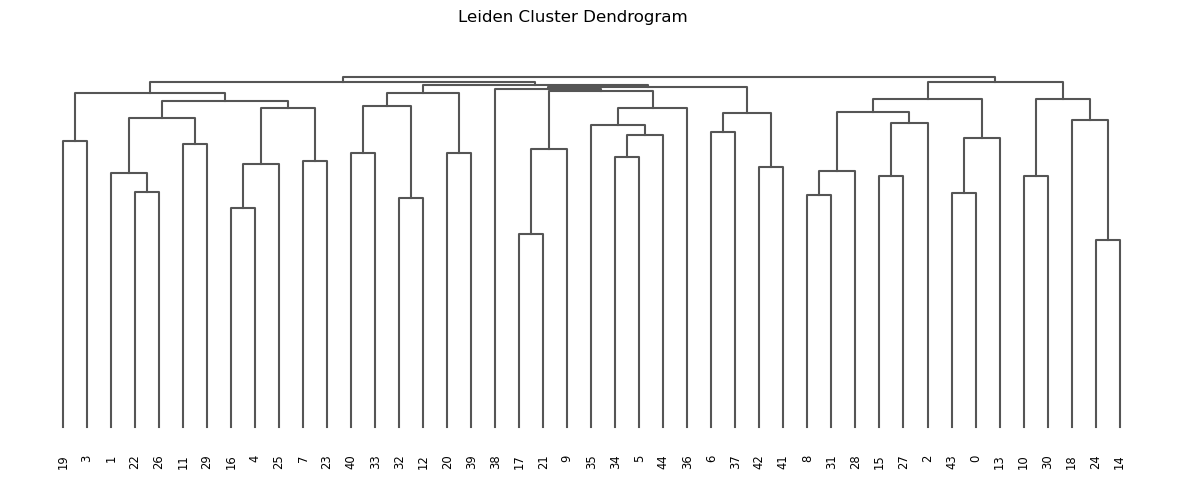

In [13]:
p_th = 0.05

''' Leiden Dendrogram '''
file_name = correlations_dict[groupby]['file_name']
plot_dendrogram(adata_train, groupby, directory=figure_path, file_name=file_name+'.png', show=False)


In [40]:
''' Cluster Purity '''
text = 'Smoking History: \n(Never smoked, Ex-smoker, Current) : (0, 1, 2)' +'\n'+'_'*50 +'\n\n'+ 'WCC Score: \n(Low, Normal, High) : (-1, 0, 1)'+'\n'+'_'*50 +'\n\n'+ 'Desmoplastic Component:\n(No, Yes) : (0, 1)'+'\n'+'_'*50 +'\n\n'+ 'N Stage (8th Edition TNM): \n(Not given (Nx), N0, N1, N2) : (-1, 0, 1, 2)'


file_name = correlations_dict['annotation']['file_name']
critical_coef, critical_ref, p_values, mask = correlations_dict['annotation']['data']
g = plot_clustermap(all_data_rho=np.round(critical_coef,2), mask=mask.values, x_label='Cluster', text=text, y_label='Patient Annotations', cox_os_clusters=coef_os_df, cox_pfs_clusters=coef_pfs_df,
                directory=figure_path, file_name=file_name+'.jpg', figsize=(60,30), show=False)
correlations_dict['annotation']['linkage'] = g.dendrogram_col.linkage

# Paper figures - Correlations

In [30]:
# p_th = 0.05

# ''' Leiden Dendrogram '''
# file_name = correlations_dict[groupby]['file_name']
# plot_dendrogram(adata_train, groupby, directory=figure_path, file_name=file_name+'.png', show=False)

# ''' Cluster Purity '''
# file_name = correlations_dict['hovernet']['file_name']
# critical_coef, critical_ref, p_values, mask = correlations_dict['hovernet']['data']
# g = plot_clustermap(all_data_rho=np.round(critical_coef,2), mask=mask.values, x_label='Cluster', y_label='Cell Annotations', cox_os_clusters=coef_os_df, cox_pfs_clusters=coef_pfs_df,
#                 directory=figure_path, file_name=file_name+'.jpg', figsize=(60,30))
# correlations_dict['hovernet']['linkage'] = g.dendrogram_col.linkage

# ''' Immune Landscape '''
# file_name = correlations_dict['immunelandscape']['file_name']
# all_data_rho, all_data_pval, mask = correlations_dict['immunelandscape']['data']
# g = plot_clustermap(all_data_rho=all_data_rho, mask=mask.values, x_label='Cluster', y_label='Immune feature', cox_os_clusters=coef_os_df, cox_pfs_clusters=coef_pfs_df,
#                     directory=figure_path, file_name=file_name+'.jpg', figsize=(65,35))
# correlations_dict['immunelandscape']['linkage'] = g.dendrogram_col.linkage




executing
executing


# Paper figures - Scatter Plot correlations

In [29]:
frames_perc = build_cohort_representations(meta_folder, meta_field, matching_field, groupby, fold_number, folds_pickle, h5_complete_path, h5_additional_path, 'percent', 100)
complete_df_perc, additional_complete_df, frame_clusters, frame_samples, features = frames_perc

frames_clr = build_cohort_representations(meta_folder, meta_field, matching_field, groupby, fold_number, folds_pickle, h5_complete_path, h5_additional_path, 'clr', 100)
complete_df_clr,  additional_complete_df, frame_clusters, frame_samples, features = frames_clr

cross_df_perc = pd.merge(complete_df_perc, annotated_df, left_on='samples', right_on='samples', how='inner')
cross_df_clr  = pd.merge(complete_df_clr,  annotated_df, left_on='samples', right_on='samples', how='inner')


Adata name: Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0
Train csv not found: /raid/users/farzaneh/Histomorphological-Phenotype-Learning/results_250/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/meso_nn250/adatas/Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0_train.csv
Train csv: /raid/users/farzaneh/Histomorphological-Phenotype-Learning/results_250/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/meso_nn250/adatas/Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0.csv
Adata name: Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0
Train csv not found: /raid/users/farzaneh/Histomorphological-Phenotype-Learning/results_250/BarlowTwins_3/Meso_250_subsampled/h224_w224_n3_zdim128/meso_nn250/adatas/Meso_250_subsampled_he_complete_combined_metadata_filtered_leiden_2p0__fold0_train.csv
Train csv: /raid/users/farzaneh/Histomorphological-Phenotype-Learning/results_250/

In [41]:
def show_correlation_scatter(cross_df, cluster, annotations, all_data_rho, all_data_pval, fontsize_labels=22, fontsize_title=30):
    from decimal import Decimal
    cross_df.columns = cross_df.columns.astype(str)

    for i, annotation in enumerate(annotations):
        print('----------------------------',annotation)
        rho_annotation  = all_data_rho.loc[annotation, str(cluster)]
        pval_annotation = all_data_pval.loc[annotation, str(cluster)]
        g = sns.jointplot(data=cross_df, x=annotation, y=str(cluster), kind='reg', ci=None, height=10, ratio=2)
        g.ax_joint.set_ylabel('HPC %s\nContribution' % cluster, fontsize=fontsize_labels, fontweight='bold')
        g.ax_joint.set_xlabel(annotation, fontsize=fontsize_labels, fontweight='bold')

        for tick in g.ax_joint.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize_labels)
            tick.label1.set_fontweight('bold')
        for tick in g.ax_joint.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize_labels)
            tick.label1.set_fontweight('bold')

        for axis in ['top','bottom','left','right']:
            g.ax_joint.spines[axis].set_linewidth(4)
            g.ax_marg_x.spines[axis].set_linewidth(4)
            g.ax_marg_y.spines[axis].set_linewidth(4)

        plt.suptitle('Spearman %s=%s\np-value=%s' % (r'$\mathbf{\rho}$', np.round(rho_annotation, 1), '%.1E' % Decimal(pval_annotation)), fontsize=fontsize_title, fontweight='bold')
        g.fig.tight_layout()
        plt.show()

---------------------------- Haemoglobin Measurement (g/dL)


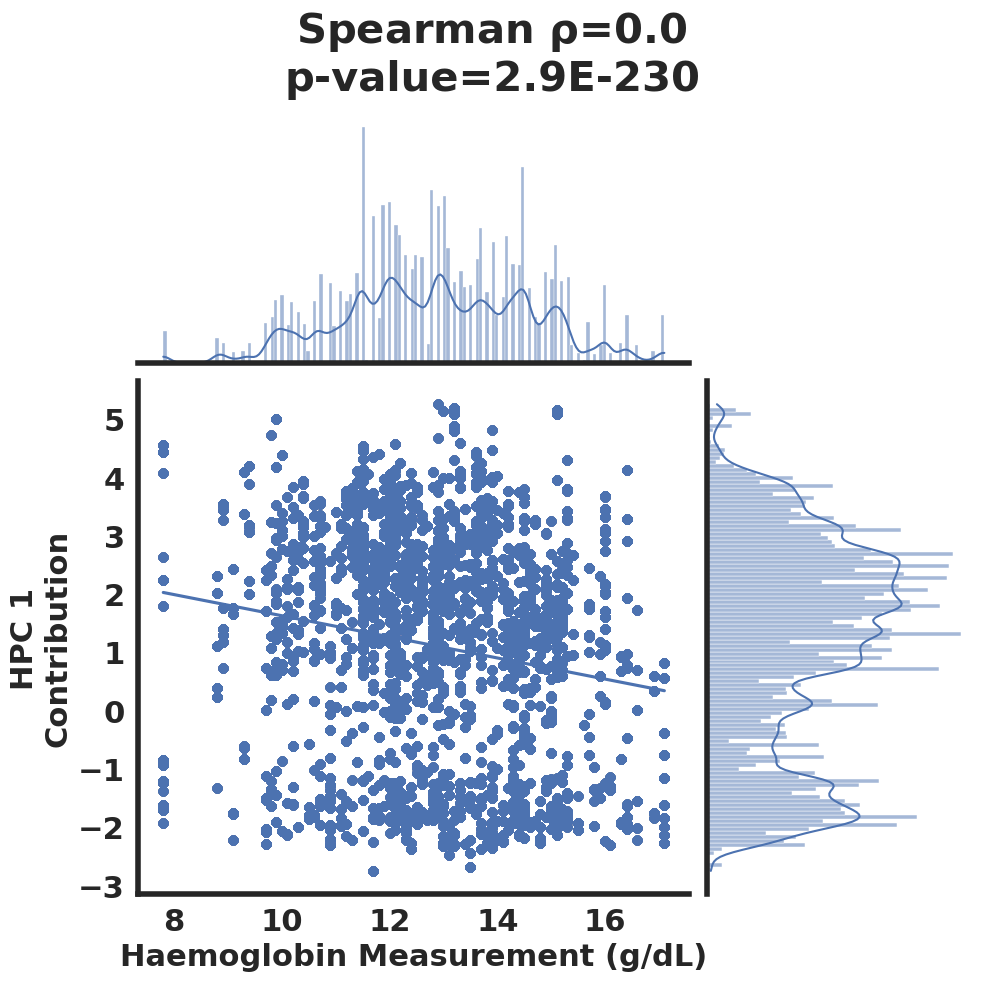

In [42]:

sns.set_theme(style='white')
cross_df_plt = cross_df_clr.copy(deep=True)
_, all_data_rho_plt, all_data_pval_plt, mask = correlations_dict['annotation']['data']
# critical_coef, critical_ref, p_values, mask = correlations_dict['annotation']['data']

show_correlation_scatter(cross_df_plt, cluster=1, annotations=['Haemoglobin Measurement (g/dL)'], all_data_rho=all_data_rho_plt, all_data_pval=all_data_pval_plt)

---------------------------- Haemoglobin Measurement (g/dL)


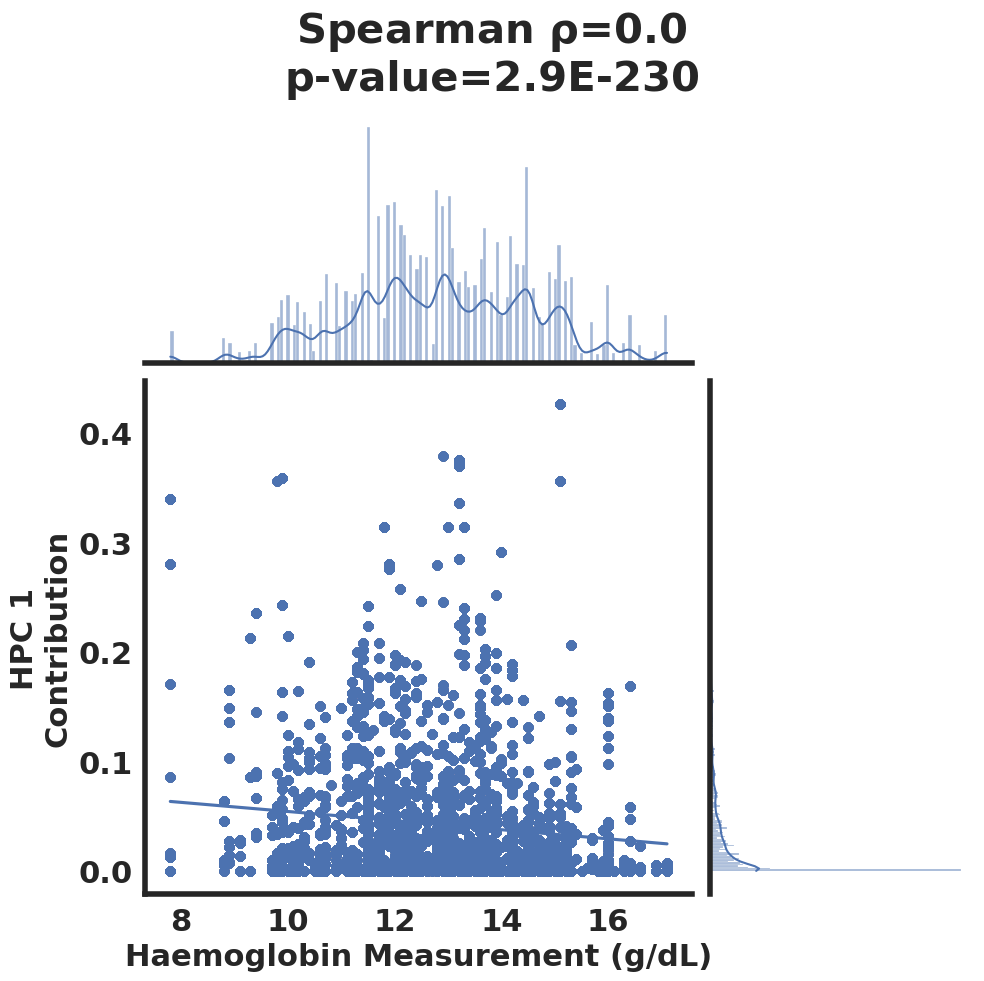

In [45]:

sns.set_theme(style='white')
cross_df_plt = cross_df_perc.copy(deep=True)
_, all_data_rho_plt, all_data_pval_plt, mask = correlations_dict['annotation']['data']
# critical_coef, critical_ref, p_values, mask = correlations_dict['annotation']['data']

show_correlation_scatter(cross_df_plt, cluster=1, annotations=['Haemoglobin Measurement (g/dL)'], all_data_rho=all_data_rho_plt, all_data_pval=all_data_pval_plt)